In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import casadi as ca
from pytope import Polytope
from matplotlib.animation import FuncAnimation

In [147]:
data_id = "08"
track_id  = 18

background_filepath = f"../data/{data_id}_background.png"
recordingMeta_filepath = f"../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../data/{data_id}_tracksMeta.csv"

tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == track_id]

xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
acc_vals= np.vstack((xAcc,yAcc))
N_Sam = acc_vals.shape[1]

xPos = filtered_data["xCenter"].to_numpy()
yPos = filtered_data["yCenter"].to_numpy()
position_vals = np.vstack((xPos,yPos))

SV_x = xPos
SV_y = yPos

xVel = filtered_data["xVelocity"].to_numpy()
yVel = filtered_data["yVelocity"].to_numpy()
velocity_vals = np.vstack((xVel,yVel))

yaw = filtered_data["heading"].to_numpy()

recordingMeta = pd.read_csv(recordingMeta_filepath)
orthoPxToMeter = recordingMeta["orthoPxToMeter"].iloc[0]

vehicle_data = pd.read_csv(tracksMeta_filepath)
filtered_vehicle_param = vehicle_data[vehicle_data['trackId'] == track_id]
sv_width = filtered_vehicle_param["width"]
sv_length = filtered_vehicle_param["length"]

print(tracks_data[(tracks_data['trackId'] == track_id) & (tracks_data['trackLifetime'] == 0)]['xAcceleration'].to_numpy())

[-0.59471]


In [148]:
def gen_drive_area(vertices):
    Drive_Area = Polytope(vertices*(0.00814636091724916*12))
    Drive_Area_visual = Polytope(vertices)
    A_road = Drive_Area.A
    b_road = Drive_Area.b
    return Drive_Area, Drive_Area_visual, A_road, b_road

road_vertices = np.array([
    [294, -59],
    [590, -388],
    [731, -221],
    [473, 88],
])

not_road_vertices = [
    np.array([
        [303, -30],
        [548, -290],
        [679, -169],
        [473, 88]
     ]),
    # np.array([
    #     [550, -303],
    #     [268, -547],
    #     [40, -224],
    #     [279, 0]
    # ]),
    # np.array([
    #     [602, -404],
    #     [888, -711],
    #     [610, -870],
    #     [241, -700]
    # ]),
    # np.array([
    #     [645, -339],
    #     [850, -96],
    #     [1100, -463],
    #     [931, -668]
    # ])
]

Drive_Area, Drive_Area_visual, A_road, b_road = gen_drive_area(road_vertices)
not_Drive_Area = []
not_Drive_Area_visual = []
not_A_road = []
not_b_road = []
for i in range(len(not_road_vertices)):
    tmp1, tmp2, tmp3, tmp4 = gen_drive_area(not_road_vertices[i])
    not_Drive_Area.append(tmp1)
    not_Drive_Area_visual.append(tmp2)
    not_A_road.append(tmp3)
    not_b_road.append(tmp4)

In [149]:
image_param = {
  "datasets": {
    "ind": {
      "scale_down_factor": 12,  
      "relevant_areas": { 
        "1": {
          "x_lim": [2000, 11500],  
          "y_lim": [9450, 0]  
        },
        "2": {
          "x_lim": [0, 12500],
          "y_lim": [7400, 0]
        },
        "3": {
          "x_lim": [0, 11500],
          "y_lim": [9365, 0]
        },
        "4": {
          "x_lim": [2700, 15448],
          "y_lim": [9365, 0]
        }
      }
    }
  }
}
location_id = "2"
scale_down_factor = image_param["datasets"]["ind"]["scale_down_factor"]
x_lim_0 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["x_lim"][0]/scale_down_factor
x_lim_1 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["x_lim"][1]/scale_down_factor
y_lim_0 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["y_lim"][0]/scale_down_factor
y_lim_1 = image_param["datasets"]["ind"]["relevant_areas"][location_id]["y_lim"][1]/scale_down_factor
x_lim_0 = 200
x_lim_1 = 900
y_lim_0 = 700
y_lim_1 = 0
image_to_real = orthoPxToMeter*scale_down_factor
real_to_image = 1/image_to_real

In [150]:
class polytope_estimation_OR():
    def __init__(self, Param):

        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.Q8 = Param["Q8"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.not_A_road = Param["not_A_road"]
        self.not_b_road = Param["not_b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        
        # sv 1
        self.U_SV_Poly1 = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H1 = self.U_SV_Poly1.A
        self.h1 = self.U_SV_Poly1.b 
        self.nv1 = np.size(self.H1, 0)
        self.nu1 = np.size(self.H1, 1)
        for i in range(self.nv1):
            self.H1[i,:] /= self.h1[i]
        self.h1 = np.ones_like(self.h1)
        self.LP1 = self.OR_LP1()
        self.theta_pre1,self.y_pre1,self.rho_pre1 = self.LP1(np.array([[0],[0]]),np.zeros((self.nu1,1)),0.1*np.ones((self.nv1,1)))
        # sv 2
        self.U_SV_Poly2 = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H2 = self.U_SV_Poly2.A
        self.h2 = self.U_SV_Poly2.b 
        self.nv2 = np.size(self.H2, 0)
        self.nu2 = np.size(self.H2, 1)
        for i in range(self.nv2):
            self.H2[i,:] /= self.h2[i]
        self.h2 = np.ones_like(self.h2)
        self.LP2 = self.OR_LP2()
        self.theta_pre2,self.y_pre2,self.rho_pre2 = self.LP2(np.array([[0],[0]]),np.zeros((self.nu2,1)),0.1*np.ones((self.nv2,1)))

        self.MPC = self.MPCFormulation()


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        G1, g1, Occupancy_SV1, G2, g2, Occupancy_SV2 = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(G1, g1, G2, g2, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV1, Occupancy_SV2

    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new):

        self.U_Hat_Poly1, self.U_Hat_Poly2 = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly1
        Reachable_Set1 = list()
        Occupancy_SV1 = list()
        x_t = np.array([SV_Pos_new[0][0], SV_Vel_new[0][0], SV_Pos_new[0][1], SV_Vel_new[0][1]])
        Reachable_Set1.append(x_t)
        G1= np.zeros((4, 2*self.N)) 
        g1 = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set1[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set1[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep( )
            temp_poly   = occupancy_SV_t
            G1[:, 2*t-2:2*t] = temp_poly.A
            g1[:, t-1]       = temp_poly.b.reshape(4, )

            Occupancy_SV1.append(temp_poly)
            Reachable_Set1.append(reachable_set_t)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly2
        Reachable_Set2 = list()
        Occupancy_SV2 = list()
        x_t = np.array([SV_Pos_new[1][0], SV_Vel_new[1][0], SV_Pos_new[1][1], SV_Vel_new[1][1]])
        Reachable_Set2.append(x_t)
        G2= np.zeros((4, 2*self.N)) 
        g2 = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set2[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set2[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep( )
            temp_poly   = occupancy_SV_t
            G2[:, 2*t-2:2*t] = temp_poly.A
            g2[:, t-1]       = temp_poly.b.reshape(4, )

            Occupancy_SV2.append(temp_poly)
            Reachable_Set2.append(reachable_set_t)

        return G1, g1, Occupancy_SV1, G2, g2, Occupancy_SV2
    

    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        Q8 = self.Q8
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        not_A_road = self.not_A_road        #driving not_area.A
        not_b_road = self.not_b_road        #driving not_area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam1 = opti.variable(4, N)
        lam2 = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G1 = opti.parameter(4, 2*N)
        g1 = opti.parameter(4, N)
        G2 = opti.parameter(4, 2*N)
        g2 = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        tmp1 = opti.variable(4,N)
        tmp2 = opti.variable(4,N)
        tmp3 = opti.variable(4,N)
        tmp4 = opti.variable(4,N)
        s1   = opti.variable(N,1)
        # s2   = opti.variable(N,1)
        # s3   = opti.variable(N,1)
        # s4   = opti.variable(N,1)
        J = 0
        

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point1 = G1[:, 2*k:2*k + 2]
            g_point1 = g1[:, k]
            G_point2 = G2[:, 2*k:2*k + 2]
            g_point2 = g2[:, k]
            temp1 = G_point1.T@lam1[:, k]
            temp2 = G_point2.T@lam2[:, k]
            scale_factor = 1.0 - 0.5 * k/N
            opti.subject_to((G_point1@ca.reshape(p_point,2,1) - g_point1).T@lam1[:, k] >= scale_factor*d_min - s[k])
            opti.subject_to((G_point2@ca.reshape(p_point,2,1) - g_point2).T@lam2[:, k] >= scale_factor*d_min - s[k])
            opti.subject_to(temp1[0]**2 + temp1[1]**2 == 1)
            opti.subject_to(temp2[0]**2 + temp2[1]**2 == 1)
            opti.subject_to(0 <= lam1[:, k])
            opti.subject_to(0 <= lam2[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)

            opti.subject_to((not_A_road[0]@ca.reshape(p_point,2,1)-not_b_road[0]).T@tmp1[:,k] >= 0.5)#- s1[k])
            opti.subject_to(ca.dot(not_A_road[0].T@tmp1[:,k],not_A_road[0].T@tmp1[:,k])<=1)

            # opti.subject_to((not_A_road[1]@ca.reshape(p_point,2,1)-not_b_road[1]).T@tmp2[:,k] >= 0.5)#- s2[k])
            # opti.subject_to(ca.dot(not_A_road[1].T@tmp2[:,k],not_A_road[1].T@tmp2[:,k])<=1)

            # opti.subject_to((not_A_road[2]@ca.reshape(p_point,2,1)-not_b_road[2]).T@tmp3[:,k] >= 0.5)#- s3[k])
            # opti.subject_to(ca.dot(not_A_road[2].T@tmp3[:,k],not_A_road[2].T@tmp3[:,k])<=1)

            # opti.subject_to((not_A_road[3]@ca.reshape(p_point,2,1)-not_b_road[3]).T@tmp4[:,k] >= 0.5)#- s4[k])
            # opti.subject_to(ca.dot(not_A_road[3].T@tmp4[:,k],not_A_road[3].T@tmp4[:,k])<=1)


        opti.subject_to(opti.bounded(0, tmp1, ca.inf))
        # opti.subject_to(opti.bounded(0, tmp2, ca.inf))
        # opti.subject_to(opti.bounded(0, tmp3, ca.inf))
        # opti.subject_to(opti.bounded(0, tmp4, ca.inf))

        # opti.subject_to(opti.bounded(0, s, d_min))
        opti.subject_to(0 <= s)
        # opti.subject_to(opti.bounded(0, s1, 3))
        # opti.subject_to(opti.bounded(0, s2, 3))
        # opti.subject_to(opti.bounded(0, s3, 3))
        # opti.subject_to(opti.bounded(0, s4, 3))
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J += delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*(s.T@s + s1.T@s1)
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G1, g1, G2, g2, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    

    def  vehicle_model(self, w, delta, eta):
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  


    def OR_LP1(self):

        H = self.H1
        nv = self.nv1
        nu = self.nu1

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    
    def OR_LP2(self):

        H = self.H2
        nv = self.nv2
        nu = self.nu2

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho]) 
    

    def OR(self,SV_Acc_new):

        self.theta_pre1,self.y_pre1,self.rho_pre1 = self.LP1(SV_Acc_new[0],self.y_pre1,self.theta_pre1)
        U_Hat_Poly1 = Polytope(self.H1, self.theta_pre1)+self.y_pre1
        self.theta_pre2,self.y_pre2,self.rho_pre2 = self.LP2(SV_Acc_new[1],self.y_pre2,self.theta_pre2)
        U_Hat_Poly2 = Polytope(self.H2, self.theta_pre2)+self.y_pre2

        return U_Hat_Poly1, U_Hat_Poly2
    

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()


    def vehicle_model(self, w, delta, eta):
        
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

In [151]:
Param = {
    "init_acc": acc_vals[:,0].reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.25, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.2, # length of vehicle
    "w_veh": 1.5, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 300,
    "Q8": 500,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "not_A_road": not_A_road, # list
    "not_b_road": not_b_road, # list
    "v_low": -0.2,
    "v_up": 0.8,
    "acc_low": -0.3,
    "acc_up": 0.3,
    "delta_low": -0.45,
    "delta_up": 0.45,
    "RefSpeed": 0,
    "RefPos": [686*image_to_real,-208*image_to_real,-0.744+np.pi/2]
}
print(686*image_to_real,-208*image_to_real)
x_EV_initial = np.array([315*image_to_real, -64*image_to_real, -0.77, 0, 0]) #bot

67.06084307079459 -20.33331684945375


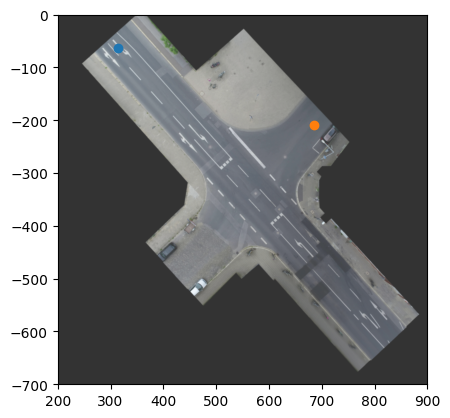

In [152]:
fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)
# Drive_Area_visual.plot(color = 'r', alpha = 0.2)
for i in range(len(not_Drive_Area_visual)):
    pass
    # not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)
plt.imshow(img,alpha = 0.8, extent=[0, img.shape[1], -img.shape[0], 0])
plt.scatter(x_EV_initial[0]*real_to_image,x_EV_initial[1]*real_to_image)
plt.scatter(Param["RefPos"][0]*real_to_image,Param["RefPos"][1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()

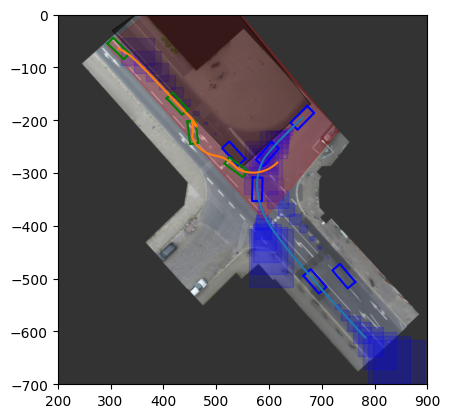

In [153]:
#test mpc
test_polytope = polytope_estimation_OR(Param)
State_EV_R     = np.zeros((5, N_Sam+1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = list( )
X_EV_Planning_R.append(x_EV_initial[0:2].reshape(2,1))

fig, ax = plt.subplots()
img   = mpimg.imread(background_filepath)

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2
i = 0
track_id = [18,29]
def reach_destination(x_EV_initial,x_ref):
    if abs(x_EV_initial[0] - x_ref[0]) <= 1 and abs(x_EV_initial[1] - x_ref[1]) <= 1:
        return False
    else:
        return True

# while(reach_destination(X_EV_Planning_R[-1],Param["RefPos"])):
for i in range(0,N_Sam):
    SV_acc = np.zeros((len(track_id),2,1))
    SV_position = np.zeros((len(track_id),2,1))
    SV_velocity = np.zeros((len(track_id),2,1))
    SV_yaw = np.zeros((len(track_id),1))
    for j in range(len(track_id)):
        sv = track_id[j]
        track_time = i
        if j == 1:
            track_time -= 50
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
        if x_acc.size == 0:
            SV_acc[j] = np.zeros((2,1))
            SV_position[j] = np.zeros((2,1))
            SV_velocity[j] = np.zeros((2,1))
            SV_yaw[j] = 0
        else:
            SV_acc[j] = np.vstack((x_acc,y_acc))
            SV_position[j] = np.vstack((x_center,y_center))
            SV_velocity[j] = np.vstack((x_vel,y_vel))
            SV_yaw[j] = yaw

    #   U_R: input, trajectory_planning_k: predicted EV, J_R:cost, Occupancy_SV_aug_R:Occupancy
    U_R, trajectory_planning_k, J_R, Occupancy_SV_aug_R1, Occupancy_SV_aug_R2 = test_polytope.Return(SV_acc, SV_position, SV_velocity, State_EV_R[:, i])
    Occupancy_SV_aug_R = [Occupancy_SV_aug_R1,Occupancy_SV_aug_R2]
    X_EV_Planning_R.append(trajectory_planning_k[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k[:, 1]
    
    if i % 80 == 0:
        corners_sv = np.array([
            [-half_length_sv, -half_width_sv],
            [half_length_sv, -half_width_sv],
            [half_length_sv, half_width_sv],
            [-half_length_sv, half_width_sv]
        ])

        for j in range(len(track_id)):
            rad_yaw_sv = np.radians(SV_yaw[j].item())
            rotation_matrix_sv = np.array([
                    [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
                    [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
                ])
            rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
            rotated_corners_sv[:, 0] += SV_position[j][0].item()*real_to_image
            rotated_corners_sv[:, 1] += SV_position[j][1].item()*real_to_image
            rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
            plt.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'b-')

            for k in range(10):
                occupancy = Polytope(Occupancy_SV_aug_R[j][k].A, Occupancy_SV_aug_R[j][k].b*real_to_image)
                occupancy.plot(color = 'b', alpha = 0.2)

        corners_ev = np.array([
            [-half_length_ev, -half_width_ev],
            [half_length_ev, -half_width_ev],
            [half_length_ev, half_width_ev],
            [-half_length_ev, half_width_ev]
        ])
        rad_yaw_ev = trajectory_planning_k[2,1]
        rotation_matrix_ev = np.array([
                [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
                [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
        rotated_corners_ev[:, 0] += State_EV_R[0, i+1]*real_to_image
        rotated_corners_ev[:, 1] += State_EV_R[1, i+1]*real_to_image
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'g-')

        
            
Drive_Area_visual.plot(color = 'r', alpha = 0.2)
for i in range(len(not_Drive_Area_visual)):
    not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)

plt.imshow(img,alpha = 0.8, extent=[0, img.shape[1], -img.shape[0], 0])
plt.plot(SV_x*real_to_image, SV_y*real_to_image)
plt.plot(State_EV_R[0]*real_to_image, State_EV_R[1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([-y_lim_0,-y_lim_1])
plt.show()

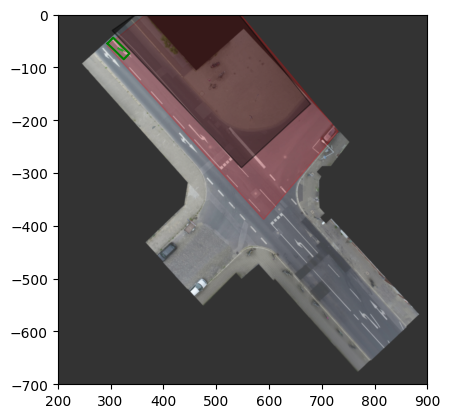

In [154]:
test_polytope = polytope_estimation_OR(Param)
fig, ax = plt.subplots()
img = mpimg.imread(background_filepath)

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
half_width_ev = real_to_image*Param["w_veh"] / 2
half_length_ev = real_to_image*Param["l_veh"] / 2
frame_length =100+ N_Sam

ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
ax.set_xlim([x_lim_0, x_lim_1])
ax.set_ylim([-y_lim_0, -y_lim_1])

State_EV_R = np.zeros((5, frame_length + 1))
State_EV_R[:, 0] = x_EV_initial
X_EV_Planning_R = []


def draw_vehicle(ax, corners, rotation_matrix, position, color):
    rotated_corners = corners.reshape(4,2) @ rotation_matrix.T
    rotated_corners[:, 0] += position[0]
    rotated_corners[:, 1] += position[1]
    rotated_corners = np.vstack([rotated_corners, rotated_corners[0]]) 
    ax.plot(rotated_corners[:, 0], rotated_corners[:, 1], color)

corners_sv = np.array([
    [-half_length_sv, -half_width_sv],
    [half_length_sv, -half_width_sv],
    [half_length_sv, half_width_sv],
    [-half_length_sv, half_width_sv]
])
corners_ev = np.array([
    [-half_length_ev, -half_width_ev],
    [half_length_ev, -half_width_ev],
    [half_length_ev, half_width_ev],
    [-half_length_ev, half_width_ev]
])

def update(frame):
    ax.clear()
    ax.imshow(img, alpha=0.8, extent=[0, img.shape[1], -img.shape[0], 0])
    ax.set_xlim([x_lim_0, x_lim_1])
    ax.set_ylim([-y_lim_0, -y_lim_1])
    
    global State_EV_R
    track_id = [18,44]
    SV_acc = np.zeros((len(track_id),2,1))
    SV_position = np.zeros((len(track_id),2,1))
    SV_velocity = np.zeros((len(track_id),2,1))
    SV_yaw = np.zeros((len(track_id),1))

    for j in range(len(track_id)):
        sv = track_id[j]
        track_time = frame
        if j == 0:
            track_time -= 10
        if j == 1:
            track_time -= 120
        x_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xAcceleration'].to_numpy()
        y_acc = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yAcceleration'].to_numpy()
        x_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xCenter'].to_numpy()
        y_center = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yCenter'].to_numpy()
        x_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['xVelocity'].to_numpy()
        y_vel = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['yVelocity'].to_numpy()
        yaw = tracks_data[(tracks_data['trackId'] == sv) & (tracks_data['trackLifetime'] == track_time)]['heading'].to_numpy()
        if x_acc.size == 0:
            SV_acc[j] = np.zeros((2,1))
            SV_position[j] = np.zeros((2,1))
            SV_velocity[j] = np.zeros((2,1))
            SV_yaw[j] = 0
        else:
            SV_acc[j] = np.vstack((x_acc,y_acc))
            SV_position[j] = np.vstack((x_center,y_center))
            SV_velocity[j] = np.vstack((x_vel,y_vel))
            SV_yaw[j] = yaw

    U_R, trajectory_planning_k, J_R, Occupancy_SV_aug_R1, Occupancy_SV_aug_R2 = test_polytope.Return(SV_acc, SV_position, SV_velocity, State_EV_R[:, frame])
    Occupancy_SV_aug_R = [Occupancy_SV_aug_R1,Occupancy_SV_aug_R2]
    X_EV_Planning_R.append(trajectory_planning_k[0:2, 1].reshape(2, 1))
    State_EV_R[:, frame + 1] = trajectory_planning_k[:, 1]

    for j in range(len(track_id)):
        rad_yaw_sv = np.radians(SV_yaw[j].item())
        rotation_matrix_sv = np.array([
            [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
            [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
        ])
        draw_vehicle(ax, corners_sv, rotation_matrix_sv, [SV_position[j][0].item()*real_to_image, SV_position[j][1].item()*real_to_image], 'b-')
        for k in range(10):
            occupancy = Polytope(Occupancy_SV_aug_R[j][k].A, Occupancy_SV_aug_R[j][k].b*real_to_image)
            occupancy.plot(color='b', alpha=0.2)

        ax.plot(SV_position[j][0]*real_to_image, SV_position[j][1]*real_to_image)

    rad_yaw_ev = trajectory_planning_k[2, 1]
    rotation_matrix_ev = np.array([
        [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
        [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
    ])
    draw_vehicle(ax, corners_ev, rotation_matrix_ev, [State_EV_R[0, frame + 1]*real_to_image,
                                                    State_EV_R[1, frame + 1]*real_to_image], 'g-')

    #print(trajectory_planning_k.shape)
    ax.plot(trajectory_planning_k[0]*real_to_image,trajectory_planning_k[1]*real_to_image)
    Drive_Area_visual.plot(color='r', alpha=0.2)
    for i in range(len(not_Drive_Area_visual)):
        not_Drive_Area_visual[i].plot(color = 'black', alpha = 0.4)

ani = FuncAnimation(fig, update, frames=range(0, frame_length), interval=100, repeat=False)
#plt.show()
ani.save("animation.mp4", writer='ffmpeg', fps=60)

In [155]:
from IPython.display import Video

# Specify the full file path
video_path = "animation.mp4"

# Display the video
Video(video_path, embed=True)